<a href="https://colab.research.google.com/github/LarrySnyder/ASJ/blob/main/compas/COMPAS_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMPAS—Part 2

This file is read-only. To work with it, you first need to **save a copy to your Google Drive:**

1. Go to the *File* menu. (The *File* menu inside the notebook, right below the filename—not the *File* menu in your browser, at the top of your screen.)
2. Choose *Save a copy in Drive*. (Log in to your Google account, if necessary.) Feel free to move it to a different folder in your Drive, if you want.
3. Colab should open up a new browser tab with your copy of the notebook. Double-click the filename at the top of the window and rename it `COMPAS [your name(s)]`. 
4. Close the original read-only notebook in your browser.


---
> 👓 **Note:** This notebook is part of the *Algorithms and Social Justice* course at Lehigh University, Profs. Larry Snyder and Suzanne Edwards.
---


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn import tree, preprocessing

## Previously On ...

In the first COMPAS notebook, you loaded and filtered the data...

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv',
                   usecols=["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
                    "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"])
pp_data = data.query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')
pp_data = pp_data.query('race == "Caucasian" | race == "African-American"')

...built a histogram to visualize COMPAS scores for Black and white defendants...

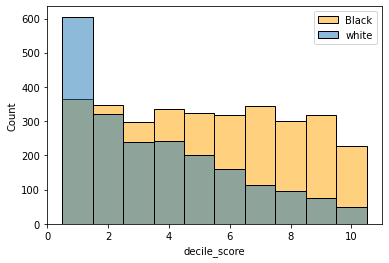

In [ ]:
sns.histplot(pp_data[pp_data["race"] == "African-American"], x="decile_score", discrete=True, color='orange', alpha=0.5)
sns.histplot(pp_data[pp_data["race"] == "Caucasian"], x="decile_score", discrete=True, alpha=0.5)
plt.legend(labels=["Black", "white"]);

...added a column specifying the COMPAS prediction (predict "will recidivate" if COMPAS score > 4, otherwise predict "won't recidivate")...

In [ ]:
threshold = 4
pp_data['COMPAS_prediction'] = 1 * (pp_data['decile_score'] > threshold)

...showed that the accuracy is similar for Black and white defendants...

In [ ]:
pp_data_black = pp_data[pp_data['race'] == 'African-American']
correct_predictions_black = pp_data_black[pp_data_black['two_year_recid'] == pp_data_black['COMPAS_prediction']]
accuracy_black = len(correct_predictions_black) / len(pp_data_black)
print(f"For Black defendants: accuracy = {accuracy_black:.4f}")
pp_data_white = pp_data[pp_data['race'] == 'Caucasian']
correct_predictions_white = pp_data_white[pp_data_white['two_year_recid'] == pp_data_white['COMPAS_prediction']]
accuracy_white = len(correct_predictions_white) / len(pp_data_white)
print(f"For white defendants: accuracy = {accuracy_white:.4f}")

For Black defendants: accuracy = 0.6491
For white defendants: accuracy = 0.6719


...and calculated the FPR and FNR for Black and white defendants:

In [ ]:
TN_black, FP_black, FN_black, TP_black = confusion_matrix(pp_data_black['two_year_recid'], pp_data_black['COMPAS_prediction']).ravel()
FPR_black = FP_black / (FP_black + TN_black)
FNR_black = FN_black / (TP_black + FN_black)
print(f"For Black defendants: FPR = {FPR_black:.4f}, FNR = {FNR_black:.4f}")
TN_white, FP_white, FN_white, TP_white = confusion_matrix(pp_data_white['two_year_recid'], pp_data_white['COMPAS_prediction']).ravel()
FPR_white = FP_white / (FP_white + TN_white)
FNR_white = FN_white / (TP_white + FN_white)
print(f"For white defendants: FPR = {FPR_white:.4f}, FNR = {FNR_white:.4f}")

For Black defendants: FPR = 0.4234, FNR = 0.2848
For white defendants: FPR = 0.2201, FNR = 0.4964


The FPR and FNR are very different for Black and white defendants, leading ProPublica (and you?) to conclude that COMPAS is racially biased. 

ProPublica is using a definition of fairness called **Equalized Odds,** which says that the TPR is equal for both groups, and so is the FPR. COMPAS fails the equalized odds test.

In the first notebook, you also built the ROC curve for COMPAS:

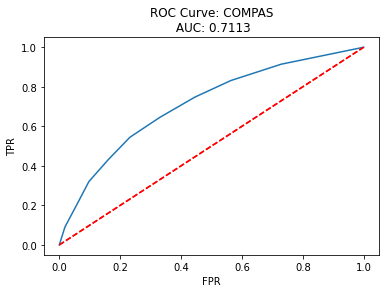

In [ ]:
FPR, TPR, _ = roc_curve(pp_data['two_year_recid'], pp_data['decile_score'])
AUC = roc_auc_score(pp_data['two_year_recid'], pp_data['decile_score'])
plt.plot(FPR, TPR)
plt.plot([(0, 0), (1, 1)], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve: COMPAS\n AUC: {AUC:.4f}');

---
> 🤓 **Nerd detail:** The `, _` is sort of funny in this line:
>
> ```
FPR, TPR, _ = roc_curve(pp_data['two_year_recid'], pp_data['decile_score'])
```
>
> What's happening here is that the function `roc_curve()` returns three values, but we only care about the first two of them. We can't just write
>
> ```
FPR, TPR = roc_curve(pp_data['two_year_recid'], pp_data['decile_score'])
```
> because Python won't let us squeeze three values into two variables. But we can use `_` in the third slot, which just means "throw this value away."
---

### Goals for This Notebook

In this notebook, we have two main goals:
* Examine the fairness argument made by Northpointe (the company that makes COMPAS, now called Equivant) 
* Discuss the concept of _explainable_ models

### Reminder of Key Metrics

Recall the **confusion matrix:**

<center>

|                     | Predicted Positive | Predicted Negative |
|---------------------|--------------------|--------------------|
| **Actual Positive** | TP                 | FN                 |
| **Actual Negative** | FP                 | TN                 |

</center>

In the confusion matrix,
- TP = true positive = actual positives that the model predicted are positive
- FN = false negative = actual positives that the model predicted are negative
- FP = false positive = actual negatives that the model predicted are positive
- TN = true negative = actual negatives that the model predicted are negative

The **accuracy** of a model is the total proportion (percentage) of individuals that are correctly classified:

<p align="center">accuracy = (TP + TN) / (TP + FN + FP + TN)</p>

We also introduced the following metrics:
- TPR = true positive rate = TP / (TP + FN) = fraction of actual positives that the model predicted are positive
- FNR = false negative rate = FN / (TP + FN) = fraction of actual positive that the model predicted are negative
- FPR = false positive rate = FP / (FP + TN) = fraction of actual negatives that the model predicted are positive
- TNR = true positive rate = TN / (FP + TN) = fraction of actual negatives that the model predicted are not positive

You can think of these as being "row-based" measures: They look at all individuals in a row (i.e., all actual positives or all actual negatives) and ask, "Of all the individuals that are actually positive [or negative], what proportion did the model correctly predict are positive [or negative]?"


---

## Northpointe's Argument

After ProPublica's [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) was published, Northpointe published a [rebuttal](https://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf), taking issues with many of ProPublica's arguments and presenting its own evidence that COMPAS is, in fact, fair.

Northpointe argued for COMPAS's fairness using two main definitions of fairness:
* Accuracy equity
* Predictive parity

We will explore each of these metrics next.


### Accuracy Equity

Northpointe argued that the overall accuracy is similar for Black and white defendants. You already showed this is true in the previous notebook, and we recapped it in the earlier section of this one. If you need yet another recap:

In [ ]:
print(f"For Black defendants: accuracy = {accuracy_black:.4f}")
print(f"For white defendants: accuracy = {accuracy_white:.4f}")

For Black defendants: accuracy = 0.6491
For white defendants: accuracy = 0.6719


Here, Northpointe is arguing that COMPAS exhibits **Accuracy Equity,** which says that the accuracy is the same for the two groups.

Northpointe further argued that the **AUC** is similar for Black and white defendants. Recall that the **ROC** curve plots the TPR vs. the FPR for various thresholds, and the AUC is the area under that curve. In the first notebook (and earlier in this one), we plotted the ROC and calculated the AUC *for all defendants.*

**Question 1**

Plot the ROC curve for only Black defendants, and the ROC curve for only white defendants, on the same plot. Also calculate the AUC for only Black defendants and the AUC for only white defendants.

You write the code to calculate 
* `FPR_black`, `TPR_black`, `AUC_black`, and
* `FPR_white`, `TPR_white`, `AUC_white`, 

and I'll write the code to build the plot.

*Hint*: Use the code above that calculates `FPR`, `TPR`, and `AUC`, but base your calculates on `pp_data_black` and `pp_data_white` instead of on `pp_data`.

In [ ]:
# Your code here:
FPR_black, TPR_black, _ = [...]
AUC_black = [...]
FPR_white, TPR_white, _ = [...]
AUC_white = [...]

# My code here:
plt.plot(FPR_black, TPR_black)
plt.plot(FPR_white, TPR_white)
plt.plot([(0, 0), (1, 1)], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['Black', 'white'])
plt.title(f'ROC Curve: COMPAS\n AUC for Black defendants: {AUC_black:.4f}\n AUC for white defendants: {AUC_white:.4f}');

The ROC curves look quite similar, and the AUC values are quite similar, between Black and white defendants. Northepoint used this as further evidence that COMPAS does not show racial bias.

### Predictive Parity

Here come two more accuracy metrics 😬:

- PPV = positive predictive value = TP / (TP + FP) = fraction of predicted positives that are actually positive
- NPV = negative predictive value = TN / (FN + TN) = fraction of predicted negatives that are actually negative

Remember that TPR, FPR, etc. are "row-based" metrics: They look at all individuals in a row (i.e., all actual positives or all actual negatives) and ask, "Of all the individuals that are actually positive [or negative], what proportion did the model correctly predict are positive [or negative]?"

In contrast, PPV and NPV are "column-based" metrics: They look at all individuals in a column (i.e., all predicted positives or all predicted negatives) and ask, "Of all the individuals that the model predicted as positive [or negative], what proportion are actually positive [or negative]?"

Let's examine the PPV and NPV for Black and white defendants.


**Question 2**

Calculate the PPV and NPV for Black and white defendants. Store them in variables called `PPV_black`, `NPV_black`, `PPV_white`, and `NPV_white`.

*Hint*: You have already calculated TN, FP, etc. for Black and white defendants. Use those variables.

In [ ]:
[...]

Northpointe points out that the PPV is similar for Black and white defendants, and so is the NPV—in fact, the PPV is even somewhat better for Black defendants. They use this to argue that COMPAS is fair. 

This is based on yet another definition of fairness, namely, **Predictive Parity,** which says that PPV is equal for the two groups, and so is NPV.

Actually, Northpointe doesn't use PPV and NPV, they use 1 – PPV and 1 – NPV. (Mathematically, the two arguments are the same, because if PPV is equal for two groups, then so is 1 – PPV, and similarly for NPV.) In their rebuttal, they give the following table, which they claim is "a corrected version of the table that [ProPublica] presented under the
heading 'Prediction Fails Differently for Black Defendants.'":

<center><img src="https://github.com/LarrySnyder/ASJ/raw/main/compas/images/northpointe_table.png" width="500"/></center>

Northpointe interprets "labeled higher risk, but didn't re-offend" as the percentage of people who were predicted "positive" (predicted to recidivate) but were actually negative, i.e., 1 – PPV.

And they interpret "labeled lower risk, yet did re-offend" as the percentage of people who were predicted "negative" (predicted not to recidivate) but were actually positive, i.e., 1 – NPV.

Let's recreate this table based on the variables you defined in Question 2.

In [ ]:
from tabulate import tabulate
table = [["Labeled Higher Risk, But Didn't Re-Offend", 
            f"{100*(1 - PPV_white):.0f}%", 
            f"{100*(1 - PPV_black):.0f}%"],
         ["Labeled Lower Risk, Yet Did Re-Offend", 
            f"{100*(1 - NPV_white):.0f}%", 
            f"{100*(1 - NPV_black):.0f}%"]]
headers = ["White", "African American"]
print(tabulate(table, headers=headers))

(Our numbers are a little different, again due to small differences in the way we processed and analyzed the data.)

## How Can They Both Be Right?

**ProPublica says:** FPR and FNR are different for different races; therefore COMPAS is unfair.

**Northpoint says:** PPV and NPV are the same for different races; therefore COMPAS is fair.

*How can they both be right?*

In the best spirit of interdisciplinary learning, we'll give two answers, one based on language and one based on math.

### Answer 1: Imprecise Language

Recall ProPublica's famous table:

<center><img src="https://github.com/LarrySnyder/ASJ/raw/main/compas/images/propublica_table.png" width="500"/></center>

ProPublica's language here is imprecise. It's clear that "labeled higher risk, but didn't re-offend" is referring to false positives (FP) and that "labeled lower risk, yet did re-offend" is referring to false negatives (FN). 

But they are not reporting the *numbers* of FP and FN, they are reporting *percentages*, which means they need to divide by something. And the captions ("Labeled Higher Risk...") are not specific enough to tell us what to divide by.

ProPublica used the **FPR and FNR**. That is, they divided by the numbers of **actual positives and negatives.** (Remember: FPR = FP / (FP + TN) and FNR = FN / (TP + FN).)

Northpointe used **1 – PPV and 1 – NPV**. That is, they divided by the numbers of of **predicted positives and negatives.** (Remember: 1 – PPV = 1 – TP / (TP + FP) = FP / (TP + FP) and 1 – NPV = 1 – TN / (FN + TN) = FN / (FN + TN).)

That's how Northpointe was able to produce a table with *exactly the same captions as ProPublica's* but with completely different results:

<center><img src="https://github.com/LarrySnyder/ASJ/raw/main/compas/images/northpointe_table.png" width="500"/></center>

### Answer 2: Mathematical Impossibility

Remember the following two definitions of fairness:

* **Equalized Odds:** TPR is equal for both groups, and so is FPR.
* **Predictive Parity:** PPV is equal for both groups, and so is NPV. 

---
> 👓 **Note:** When we say "equal," we mean equal in a sort of statistical, expected-value sense. In practice, with real data, these metrics will not typically be equal. But if they are equal*ish*, we can say the model is fair*ish* with respect to equalized odds and/or predictive parity.
---

Using these terms, we can rephrase the two arguments as:

**ProPublica says:** equalized odds **does not hold** for COMPAS; therefore COMPAS is unfair.

**Northpoint says:** predictive parity **does hold** for COMPAS; therefore COMPAS is fair.

It turns out that this is inevitable, from a mathematical point of view, due to the following **impossibility theorem:**

> **Theorem.** Equalized odds and predictive parity cannot both hold for the same predictor, unless the predictor is *perfect* or the two groups have the *same base rate.*

(This theorem was proved after, and largely in response to, the ProPublica–Northpointe debate. See [Chouldechova (2016)](https://arxiv.org/abs/1610.07524), [Kleinberg, et al. (2016)](https://arxiv.org/abs/1609.05807), and [Miconi (2017)](https://arxiv.org/abs/1707.01195).)

By "perfect," we mean the predictor gets it right 100% of the time. Few predictors are perfect. COMPAS certainly is not.

By "same base rate," we mean that the two groups have the same prevalence of the thing being predicted. In the case of COMPAS, this would mean that Black and white defendants have the same two-year-recidivism rate. 

The data tells us that this is not the case:

In [ ]:
did_recidivate_black = pp_data_black[pp_data_black['two_year_recid'] == 1]
base_rate_black = len(did_recidivate_black) / len(pp_data_black)
did_recidivate_white = pp_data_white[pp_data_white['two_year_recid'] == 1]
base_rate_white = len(did_recidivate_white) / len(pp_data_white)
print(f"Proportion of Black defendants who recidivated = {base_rate_black:.4f}")
print(f"Proportion of White defendants who recidivated = {base_rate_white:.4f}")

The two base rates are not the same. Of course, this is not a surprise, for reasons we have already discussed in class: As [Michelle Alexander](https://newjimcrow.com/) has argued, the U.S. criminal justice system essentially criminalizes Blackness; and as [Cathy O'Neil](https://www.penguinrandomhouse.com/books/241363/weapons-of-math-destruction-by-cathy-oneil/) and others have argued, PredPol and other predictive policing algorithms ensure that Black communities are over-policed.

So: no model is a perfect predictor, and different races have different base rates of recividism — hence, it is *mathematically impossible* for COMPAS or any other model to be fair in terms of both equalized odds and predictive parity.

**Question 3**

Does one of these fairness measures resonate with you more strongly? Does one seem "fairer" than the other? If you had to choose one for your model, which would you choose, and why?

**Answer:** *YOUR ANSWER HERE*

---

## On Transparency (or Lack Thereof)

There has been a lot of discussion in recent years about the fact that many machine learning (ML) and other models are *black boxes,* and therefore that they make it difficult for humans—even the humans who designed the algorithms—to understand what the model is doing, and why. Therefore, there has been a lot of research in the ML community to develop *explainable ML*, or to develop models that are *interpretable* in the first place. In this section, we'll explore these terms (black box, explainable, interpretable) in the context of COMPAS.

Of course, being able to understand what a model is doing is important for fairness. Recall O'Neil's argument that *opacity* is one of the three hallmarks of a weapon of math destruction (WMD).

### Black Boxes, Explainability, and Interpretability

In her [paper](https://www.nature.com/articles/s42256-019-0048-x) "Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead," Cynthia Rudin argues that there are two types of **black boxes:**

> A black box model could be either (i) a function that is too complicated for any human to comprehend, or (ii) a function that is proprietary

For example, deep learning models tend to be the first type of black boxes—even if we understand the structure of the algorithm, the calculations are so complicated that trying to trace the intuition behind the decisions being made at each iteration of the algorithm quickly becomes hopeless.

On the other hand, COMPAS is the second kind of black box—we don't know what it's doing, simply because Northpointe won't tell us. They regard it as a trade secret. (It's possible that COMPAS is also the first type of black box. However, in [another paper](https://hdsr.mitpress.mit.edu/pub/7z10o269/release/7), Rudin provides evidence that it is probably not—it is probably a relatively simple model.)

Rudin decries the recent trend toward **explainable ML:**

> there has been a recent explosion of
work on “Explainable ML,” where a second (posthoc) model is created to explain the first black box model. This is problematic. Explanations are often not reliable, and can be misleading

In fact, she argues that ProPublica's attempts to recreate COMPAS's black box are incorrect, and that ProPublica draws incorrect conclusions as a result. But that's another story, which we won't get into here.

Rudin argues that instead of trying to explain ML models, we should instead be using

> models that are inherently interpretable, they provide their own explanations, which are faithful to what the model actually computes.

In other words, an **interpretable** model is transparent from the get-go, whereas explainable ML tries to reverse-engineer intuition from a black box. 

In the rest of this notebook, we'll build an interpretable model to predict recidivism. We'll evaluate its accuracy and compare it to the black-box COMPAS model.


---
> ⚠️ **Important:** In the first COMPAS notebook, you reproduced ProPublica's analysis of the COMPAS results. In the rest of this notebook, you'll instead be trying to replicate what COMPAS does—using characteristics of a defendant to predict whether they will recidivate—but using an interpretable model rather than a black box. In other words, you'll be building a competitor to COMPAS.
---



### Recap: The "Titanic" Model

In the next section, you will build a **decision tree** model to predict recidivism risk. Recall from the "Titanic" notebook that a decision tree is a type model that uses a series of "branches" (yes/no answers to questions about the data) to lead to a prediction. Because the decision tree is "trained" using data (that is, because the choices of which features to branch on is driven by data), decision trees are considered to be a type of ML model.

Here's a quick recap of how we built the decision tree in the "Titanic" notebook.


In [ ]:
# Load the data.
train_url = "https://raw.githubusercontent.com/datacamp/datacamp_facebook_live_titanic/master/data/train.csv"
train = pd.read_csv(train_url)

In [ ]:
# Clean the data.
train["Age"] = train["Age"].fillna(train["Age"].median())

In [ ]:
# Convert "Sex" to a numeric value instead of text (because that's what the 
# algorithm requires).
encoded_sex = preprocessing.LabelEncoder()
train["Sex_numeric"] = encoded_sex.fit_transform(train["Sex"])

In [ ]:
# Create arrays for the "target" (the outcome variable, i.e., value we are 
# trying to predict, in this case the "Survived" column) and the "features" 
# (the predictive variables, i.e., the values we are using to make the prediction,
# in this case the fare class, sex, age, and fare).
target = train["Survived"].values
feature_names = ["Pclass", "Sex_numeric", "Age", "Fare"]
features = train[feature_names].values

In [ ]:
# Create the decision tree and fit it.
my_tree = tree.DecisionTreeClassifier(max_depth=2)
my_tree = my_tree.fit(features, target)

*Note*: We didn't use the argument `max_depth=2` in the "Titanic" notebook, but we'll use it here. It keeps the tree smaller and more manageable.

In [ ]:
# Draw a plot of the decision tree.
plt.figure(figsize=(10, 10))
tree.plot_tree(my_tree, feature_names=feature_names, class_names=["NO", "YES"], max_depth=2, filled=True);

Another way of visualizing the decision tree, instead of drawing it, is to have the decision tree list its decision rules in text form:

In [ ]:
print(tree.export_text(my_tree, feature_names=feature_names))

Both of these outputs tell us the same thing; they translate to the following rules, in human language:

* If `Sex_numeric` = 0 (this means that `Sex` = "female"):
  * If `Pclass` ≤ 2, predict **YES** (the passenger survived)
  * If `Pclass` = 3, predict **NO** (the passenger did not survived)
* If `Sex_numeric` = 1 (`Sex` = "male"):
  * If `Age` ≤ 6.5, predict **YES**
  * If `Age` > 6.5, predict **NO**

A decision tree is inherently **interpretable,** because we know exactly how it is making the predictions it is making. If the model looks at a 10-year-old boy and predicts that he died, we know the logic that led to the model's decision. If it turns out the boy survived, we can understand where the model went wrong. If it turns out that the boy was actually 5, not 10, we can understand how the result would change.

### Building a Decision Tree Model for Recidivism Risk

Now it's your turn. You'll build a decision tree for recidivism risk. One option would be to use the 137 features on Northpointe's questionairre as your predictive variables—that's what the COMPAS tool does. But (a) we don't have those data, and (b) it turns out we can build a pretty good predictor with much simpler, less intrusive features. So that's what we'll do.

Earlier in this notebook, you already loaded ProPublica's dataset and did some filtering. At this point, the notebook should still remember the resulting DataFrame, called `pp_data`. (If not, just re-run the cells up to this point.)

Let's double-check:

In [ ]:
pp_data

### Building the Model

**Question 4**

The decision tree algorithm requires the features to be stored as numbers, not text. So, just like we converted "Sex" to a numeric value in the "Titanic" data, we'll convert both "sex" and "race" to numeric values in the ProPublica data. I'll do "sex", you do "race".

In [ ]:
# Convert values in "sex" column to numeric values.
encoded_sex = preprocessing.LabelEncoder()
pp_data['sex_numeric'] = encoded_sex.fit_transform(pp_data['sex'])

# Convert values in "race" column to numeric values.
encoded_race = [...]
pp_data['race_numeric'] = [...]

Next, we have to split our data into **testing data** and **training data.** We'll use a 70/30 split. In the "Titanic" notebook, the dataset was already split (because it was part of a competition, and the outcome variables were removed from the training data).

There are several ways to do this; for a discussion of a few of them, see https://stackoverflow.com/q/24147278/3453768. It's OK if you don't understand the next code block.

In [ ]:
train = pp_data.sample(frac=0.7, random_state=200)
test = pp_data.drop(train.index)

Next, we have to create arrays for the `target` and the `features`. 

**Question 5**

Create a variable called `target` and set it equal to the values in the `two_year_recid` column in the `train` DataFrame.

In [ ]:
[...]

**Question 6**

We'll use `age`, `race_numeric`, `sex_numeric`, `priors_count`, and `days_b_screening_arrest` as our features. 

Create a variable called `feature_names` and set it equal to a list of these column names. (Use the "Titanic" recap code as a template. Don't forget to enclose the column names in quotes.)

In [ ]:
[...]

**Question 7**

Create a variable called `features` and set it equal to the values in the columns of the `train` DataFrame corresponding to the features listed in `feature_names`. (Again, use the "Titanic" recap code as a template.)

In [ ]:
[...]

**Question 8**

Create a new decision tree, called `my_tree`, and fit it. Use a `max_depth` of 2. (Keep using the "Titanic" recap...)

In [ ]:
[...]

**Question 9**

Draw a plot of the decision tree. You can use the same `class_names` that we used in "Titanic". (Here, "NO" will mean we predict the defendant will not recidivate and "YES" will mean we predict they will.)

In [ ]:
[...]

**Question 10**

Have the decision tree list its decision rules in text form.

In [ ]:
[...]

**Question 11**

Write the decision rules in human language. (If you want to use the same formatting as we did in "Titanic", double-click the text cell, copy the text, paste it below, and edit as needed. But it's fine if you don't format it in any particular way.)



**Answer:** *YOUR ANSWER HERE*

### Evaluating the Model

We'd like to know how accurate this model is, especially compared to COMPAS. If its accuracy is much worse, it suggests that there is a tradeoff (at least in this case) between accuracy and transparency—if we want one, we can't have the other. On the other hand, if our model is still pretty accurate, it suggests we can have both.

You already built `target` and `features` arrays for the training data. But now we want to test our model on the testing data, so we'll need arrays for the testing data too.

**Question 12**

Build two new variables, called `target_test` and `features_test`. Set `target_test` equal to the values in the `two_year_recid` column in the `test` DataFrame. Set `features_test` equal to the values in the columns of the `test` DataFrame corresponding to the features listed in `feature_names`. (You don't need to define `feature_names` again; it's still the same as last time.)

In [ ]:
[...]

Now we can calculate the accuracy of your model on the testing data:

In [ ]:
# Calculate accuracy on testing data.
my_tree.score(features_test, target_test)

**Question 13**

How good is the accuracy of your decision tree model, compared to the accuracy of COMPAS?

**Answer:** *YOUR ANSWER HERE*

### Wrapping Up

Rudin argues that there is great value to having an interpretable model. She uses a different method for building a decision tree, but the overall approach is similar. The decision rules she winds up with are:

<center><img src="https://github.com/LarrySnyder/ASJ/raw/main/compas/images/rudin_rules.png" width="600"/></center>

Her model's accuracy is slightly better than the accuracy of your decision tree.

We could dig deeper to evaluate racial bias in the decision tree model, as ProPublica and Northpointe did for the COMPAS model. We won't do that in this notebook, but *feel free to do it on your own!* (It's not hard; you'd just be following the same templates that we've used already.)

If you did that analysis, though, you'd find that:
* The accuracy is similar for Black and white defendants (66% vs. 64%).
* Under ProPublica's fairness measure (equalized odds, based on FPR and FNR), the decision tree model fares as badly as COMPAS, if not worse.
* Under Northpointe's fairness measure (predictive parity, based on PPV and NPV), the decision tree model is a mixed bag: pretty equal in terms of NPV but pretty unequal in terms of PPV, with white defendants having worse accuracy than Black defendants in the latter sense.



**Question 14**

What would be some of the advantages and disadvantages of using your decision tree model instead of COMPAS? 

**Answer:** *YOUR ANSWER HERE*